In [45]:
#pip install torch

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [71]:
file_path = "/Users/amulya/Desktop/Capstone/DSCI-601-Amy/Data/FeatureEngineered/AKAM_feature_engineeredv2.csv"  
data = pd.read_csv(file_path)

data.fillna(method='ffill', inplace=True)

/var/folders/69/00tjyfg95_d37pp6ql47yf9h0000gn/T/ipykernel_21998/3782561420.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [72]:
data.dropna(inplace=True)

In [73]:
data.isnull().sum()

date               0
TICKER             0
CUSIP              0
COMNAM             0
RET                0
VOL_CHANGE         0
BA_SPREAD          0
ILLIQUIDITY        0
sprtrn             0
TURNOVER           0
PRC                0
SHROUT             0
MARKET_CAP         0
TRAN_COST          0
ASK                0
BID                0
day_of_week        0
day_of_month       0
month              0
is_month_start     0
is_month_end       0
year               0
week               0
RET_ema_12         0
RET_ema_26         0
RET_skew_10        0
RET_kurtosis_10    0
RET_entropy_10     0
RSI                0
OBV                0
RET_lag_1          0
RET_lag_7          0
RET_lag_14         0
RET_lag_30         0
RET_mean_7d        0
RET_std_7d         0
RET_mean_14d       0
RET_std_14d        0
RET_mean_30d       0
RET_std_30d        0
dtype: int64

In [74]:
features = data[['RET', 'VOL_CHANGE', 'BA_SPREAD', 'ILLIQUIDITY', 'TURNOVER', 'PRC', 
                 'RET_ema_12', 'RET_ema_26', 'RET_mean_7d', 'RET_std_7d',
                 'RET_mean_14d', 'RET_std_14d', 'RET_mean_30d', 'RET_std_30d',
                 'RET_lag_7', 'RET_lag_14', 'RET_lag_30']]
targets = data[['RET', 'PRC']]  


scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)
targets_scaled = scaler_targets.fit_transform(targets)

# Create sequences for LSTM
sequence_length = 30

def create_sequences(data, targets, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Create input sequence
        y.append(targets[i + seq_length])  # Target at the end of sequence
    return np.array(X), np.array(y)

X, y = create_sequences(features_scaled, targets_scaled, sequence_length)

# Convert to PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TimeSeriesDataset(X, y)

# Train-test split
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Define LSTM Model

In [75]:
import torch
import torch.nn as nn

class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, bidirectional=True):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional
        )
        self.attention = nn.Linear(hidden_size * (2 if bidirectional else 1), 1)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attention_weights * lstm_out, dim=1)
        output = self.fc(context)
        return output

# Initialize the model
input_size = features.shape[1]  # Number of features
hidden_size = 128  # LSTM hidden size
output_size = targets.shape[1]  # Number of targets

model = LSTMWithAttention(input_size, hidden_size, output_size)


### Train modelv1

In [76]:
import torch.optim as optim

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
model.train()

for epoch in range(epochs):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Convert batches to tensors
        X_batch = torch.tensor(X_batch, dtype=torch.float32)
        y_batch = torch.tensor(y_batch, dtype=torch.float32)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


/var/folders/69/00tjyfg95_d37pp6ql47yf9h0000gn/T/ipykernel_21998/3178548303.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.float32)
/var/folders/69/00tjyfg95_d37pp6ql47yf9h0000gn/T/ipykernel_21998/3178548303.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float32)


Epoch 1/100, Loss: 0.0060
Epoch 2/100, Loss: 0.0018
Epoch 3/100, Loss: 0.0017
Epoch 4/100, Loss: 0.0017
Epoch 5/100, Loss: 0.0017
Epoch 6/100, Loss: 0.0017
Epoch 7/100, Loss: 0.0017
Epoch 8/100, Loss: 0.0017
Epoch 9/100, Loss: 0.0017
Epoch 10/100, Loss: 0.0017
Epoch 11/100, Loss: 0.0017
Epoch 12/100, Loss: 0.0017
Epoch 13/100, Loss: 0.0017
Epoch 14/100, Loss: 0.0016
Epoch 15/100, Loss: 0.0016
Epoch 16/100, Loss: 0.0017
Epoch 17/100, Loss: 0.0017
Epoch 18/100, Loss: 0.0017
Epoch 19/100, Loss: 0.0017
Epoch 20/100, Loss: 0.0017
Epoch 21/100, Loss: 0.0017
Epoch 22/100, Loss: 0.0016
Epoch 23/100, Loss: 0.0016
Epoch 24/100, Loss: 0.0017
Epoch 25/100, Loss: 0.0017
Epoch 26/100, Loss: 0.0016
Epoch 27/100, Loss: 0.0017
Epoch 28/100, Loss: 0.0016
Epoch 29/100, Loss: 0.0016
Epoch 30/100, Loss: 0.0016
Epoch 31/100, Loss: 0.0016
Epoch 32/100, Loss: 0.0016
Epoch 33/100, Loss: 0.0016
Epoch 34/100, Loss: 0.0016
Epoch 35/100, Loss: 0.0016
Epoch 36/100, Loss: 0.0016
Epoch 37/100, Loss: 0.0016
Epoch 38/1

### Evaluate Model

In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, test_loader, scaler_targets):
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.float()
            y_batch = y_batch.float()

            outputs = model(X_batch)
            predictions.append(outputs.detach().numpy())
            actuals.append(y_batch.numpy())

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    # Inverse scaling
    predictions = scaler_targets.inverse_transform(predictions)
    actuals = scaler_targets.inverse_transform(actuals)

    # Metrics
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    # Sharpe Ratio
    if np.std(actuals[:, 0]) == 0:
        sharpe_ratio = np.nan
    else:
        sharpe_ratio = np.mean(actuals[:, 0]) / np.std(actuals[:, 0])

    # Directional accuracy
    direction_pred = np.sign(predictions[:, 0])
    direction_actual = np.sign(actuals[:, 0])
    directional_accuracy = (direction_pred == direction_actual).mean()

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2,
        "sharpe_ratio": sharpe_ratio,
        "directional_accuracy": directional_accuracy * 100,
    }


In [78]:
# Evaluate the model
metrics = evaluate_model(model, test_loader, scaler_targets)




Mean Absolute Error (MAE): 0.0140
Mean Squared Error (MSE): 0.0008
R-Squared (R²): 0.4841
Sharpe Ratio: -0.0345
Directional Accuracy: 49.50%


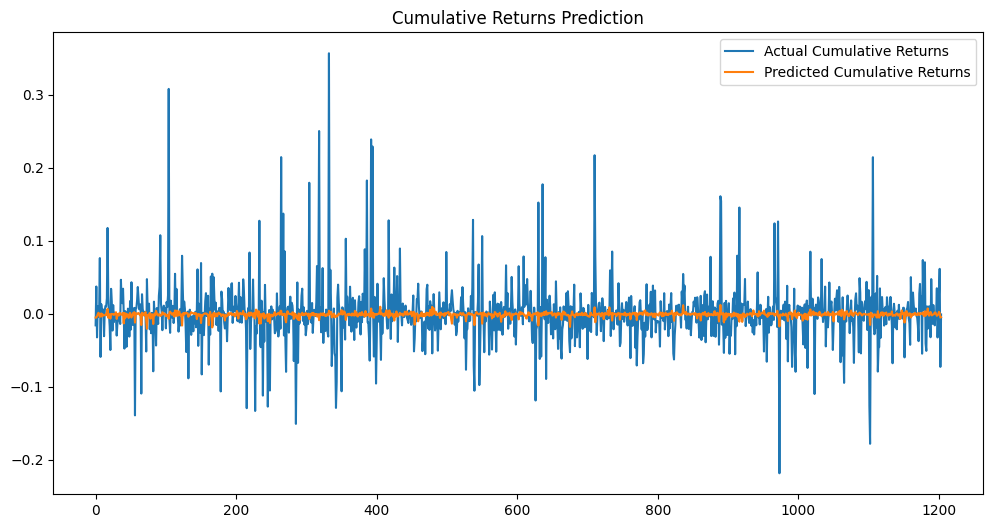

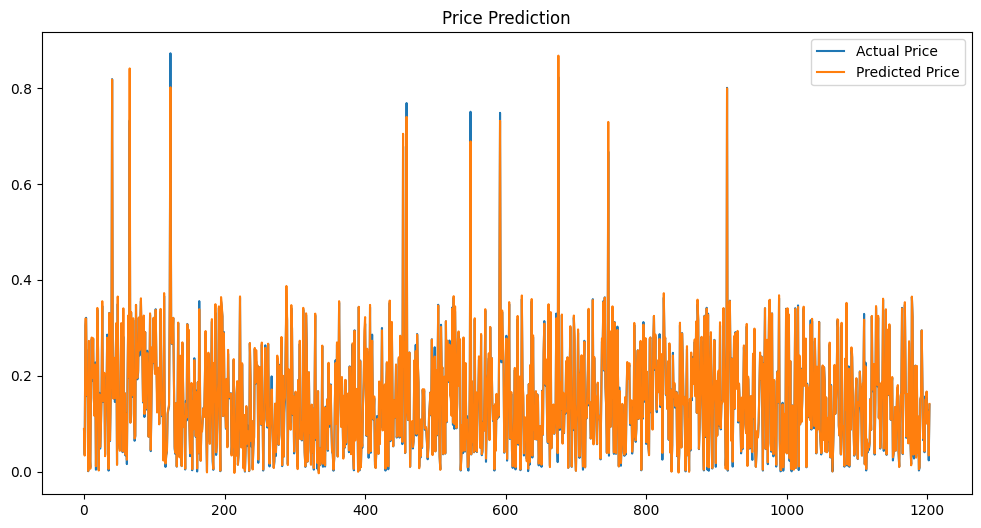

In [69]:
import matplotlib.pyplot as plt

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(actuals[:, 0], label="Actual Cumulative Returns")
plt.plot(predictions[:, 0], label="Predicted Cumulative Returns")
plt.legend()
plt.title("Cumulative Returns Prediction")
plt.show()

# Plot price
plt.figure(figsize=(12, 6))
plt.plot(actuals[:, 1], label="Actual Price")
plt.plot(predictions[:, 1], label="Predicted Price")
plt.legend()
plt.title("Price Prediction")
plt.show()
